# About Dataset
There has been a revenue decline in a Portuguese Bank and they would like to know what actions to take. After investigation, they found that the root cause was that their customers are not investing enough for long term deposits. So the bank would like to identify existing customers that have higher chance to subscribe for a long term deposit and focus marketing efforts on such customers.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install imblearn --user

In [3]:
# import data modelling libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
# load the dataset
data= pd.read_csv("train.csv")

# check shape of dataset
print("shape of the data:", data.shape)
data.head()

shape of the data: (32950, 16)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [5]:
# check data types of all columns
data.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

### check missing data 
One of the main steps in data preprocessing is handling missing data. Missing data means absence of observations in columns that can be caused while procuring the data, lack of information, incomplete results etc. Feeding missing data to your machine learning model could lead to wrong prediction or classification. Hence it is necessary to identify missing values and treat them.

In [6]:
data.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

### check for class imbalance

In [7]:
# target class count
data["y"].value_counts()

no     29238
yes     3712
Name: y, dtype: int64

Text(0.5, 1.0, 'target variable')

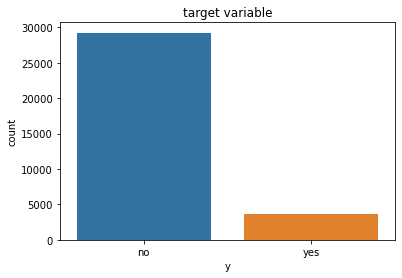

In [8]:
sns.countplot(data["y"])
plt.title("target variable")

In [9]:
# percentage of class present in target variable(y) 
print("percentage of NO and YES\n",data["y"].value_counts()/len(data)*100)

percentage of NO and YES
 no     88.734446
yes    11.265554
Name: y, dtype: float64


The class distribution in the target variable is ~89:11 indicating an imbalance dataset

## Exploratory Data Analysis
### univariate analysis of categorical variables

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')


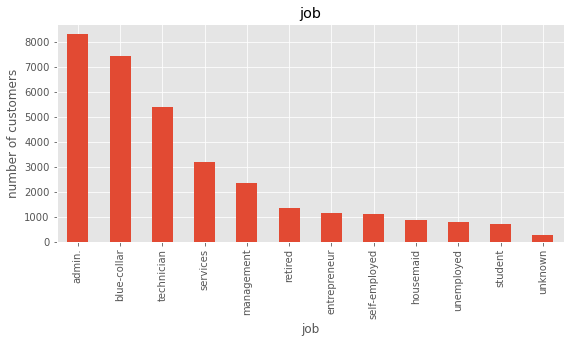

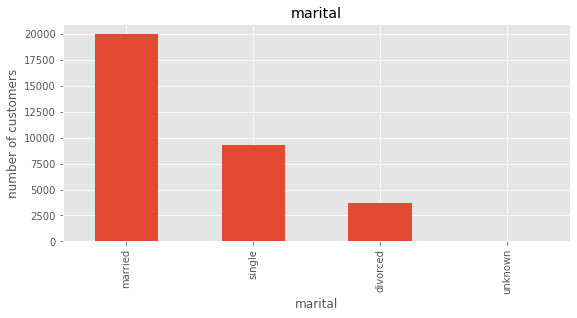

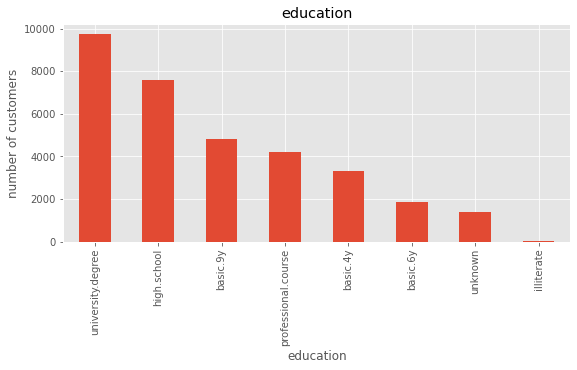

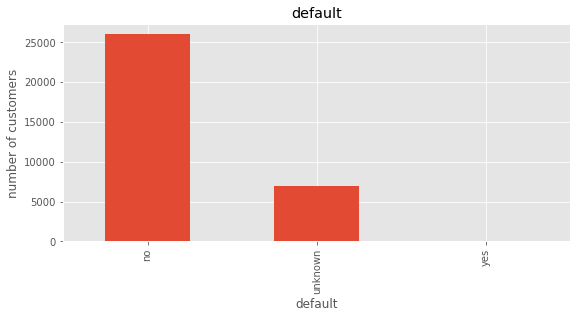

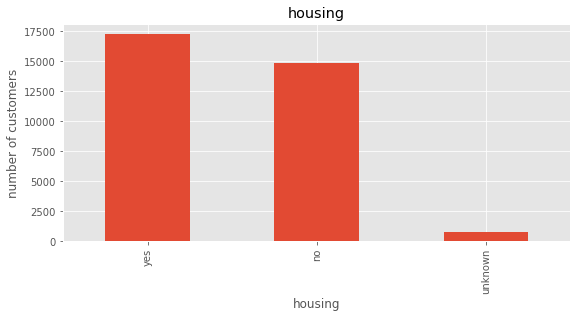

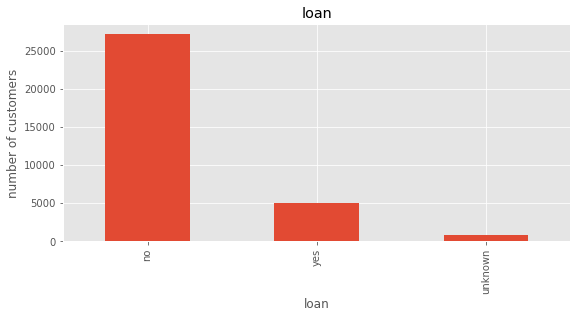

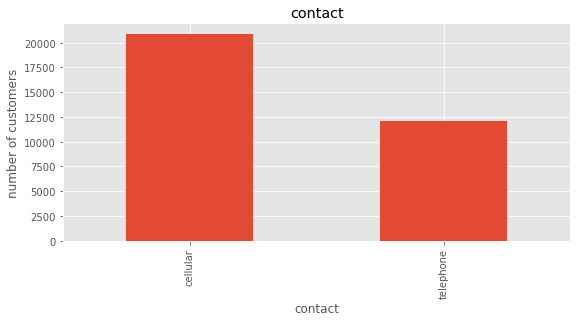

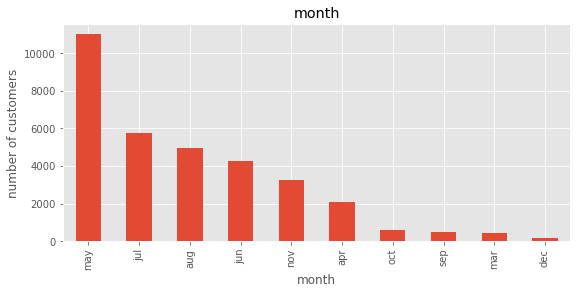

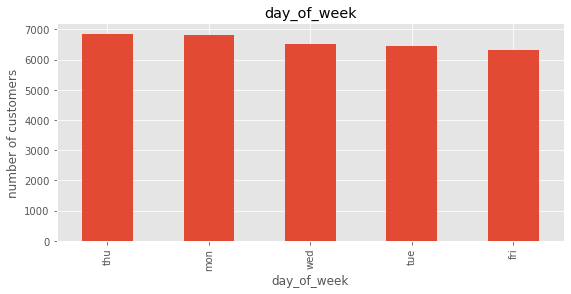

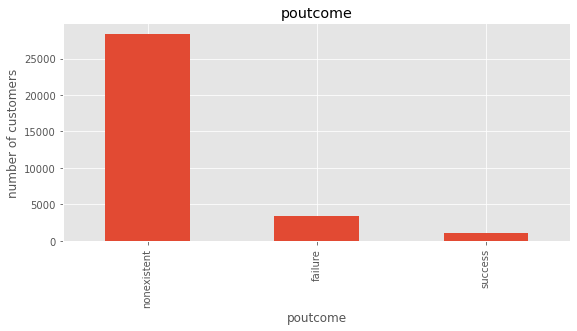

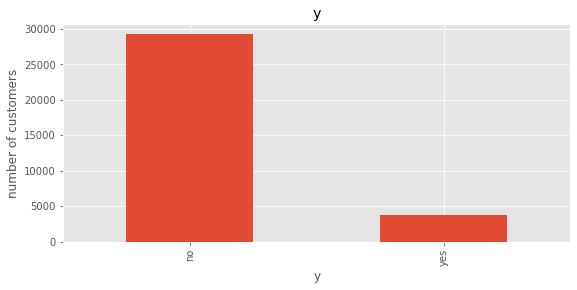

In [10]:
# indentifying the categorical variables
cat_var= data.select_dtypes(include= ["object"]).columns
print(cat_var)

# plotting bar chart for each categorical variable
plt.style.use("ggplot")

for column in cat_var:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    data[column].value_counts().plot(kind="bar")
    plt.xlabel(column)
    plt.ylabel("number of customers")
    plt.title(column)

### Observations :
- The top three professions that our customers belong to are - administration, blue-collar jobs and technicians.
- A huge number of the customers are married.
- Majority of the customers do not have a credit in default
- Many of our past customers have applied for a housing loan but very few have applied for personal loans.
- Cell-phones seem to be the most favoured method of reaching out to customers.
- Many customers have been contacted in the month of **May**.
- The plot for the target variable shows heavy imbalance in the target variable. 

The missing values in some columns have been represented as `unknown`. `unknown` represents missing data.

In [11]:
# replacing "unknown" with the mode
for column in cat_var:
    mode= data[column].mode()[0]
    data[column]= data[column].replace("unknown", mode)

### Univariate analysis of Numerical columns

In [12]:
# indentifying the numerical variables
num_var= data.select_dtypes(include=np.number)
num_var.head()

,age,duration,campaign,pdays,previous
0,49,227,4,999,0
1,37,202,2,999,1
2,78,1148,1,999,0
3,36,120,2,999,0
4,59,368,2,999,0


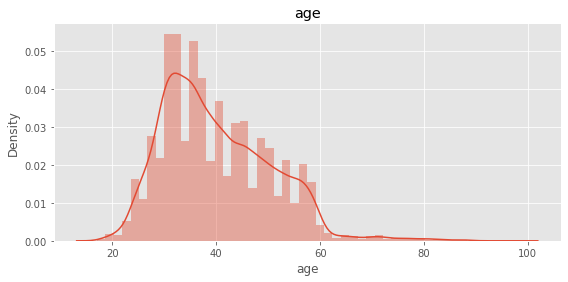

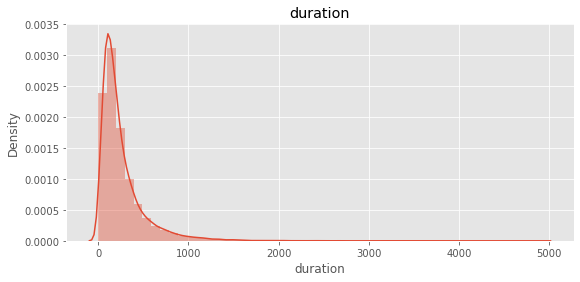

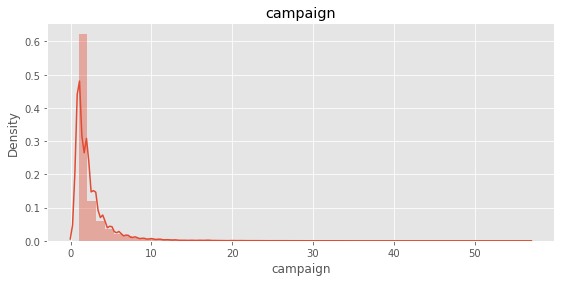

In [13]:
# plotting histogram for each numerical variable
plt.style.use("ggplot")
for column in ["age", "duration", "campaign"]:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(data[column], kde=True)
    plt.title(column)

### Observation :
- As we can see from the histogram, the features `age`, `duration` and `campaign` are heavily skewed and this is due to the presence of outliers as seen in the boxplot for these features. 
- Looking at the plot for `pdays`, we can infer that majority of the customers were being contacted for the first time because as per the feature description for `pdays` the value 999 indicates that the customer had not been contacted previously. 


Since `pdays` and `previous` consist majorly only of a single value, their variance is quite less and hence we can drop them since technically will be of no help in prediction.

In [14]:
data.drop(columns=["pdays", "previous"], axis=1, inplace=True)

### Bivariate Analysis of  Categorical Columns

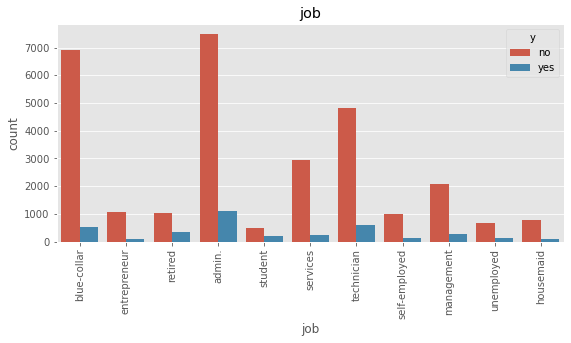

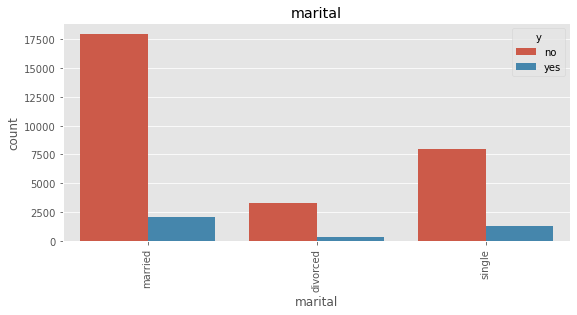

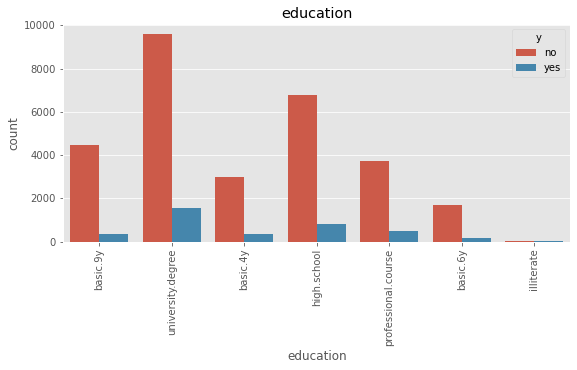

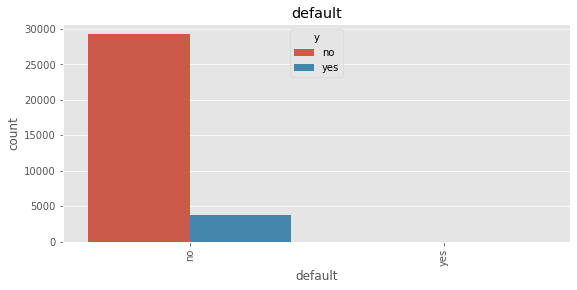

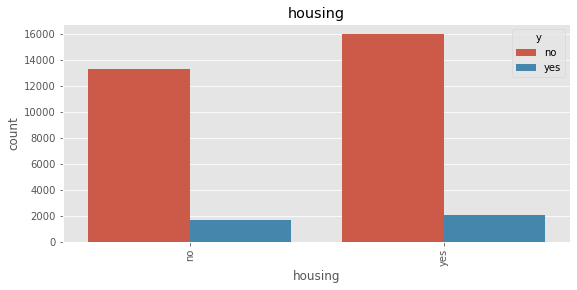

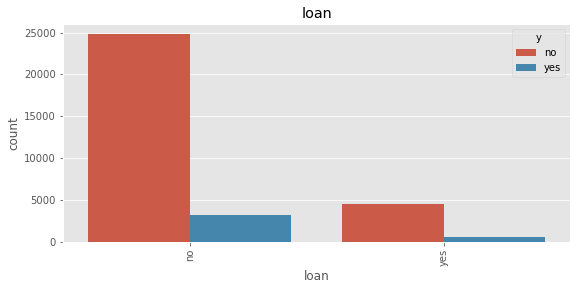

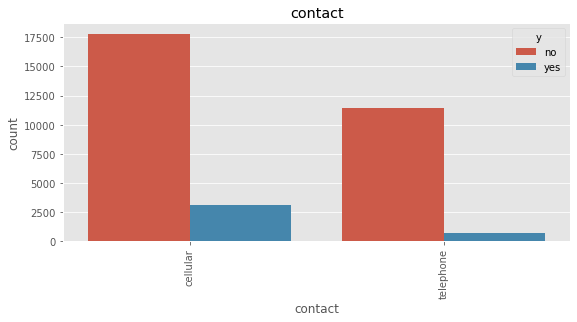

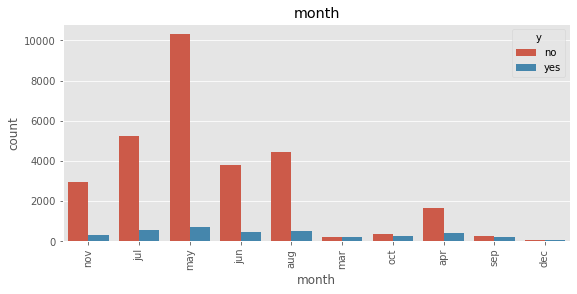

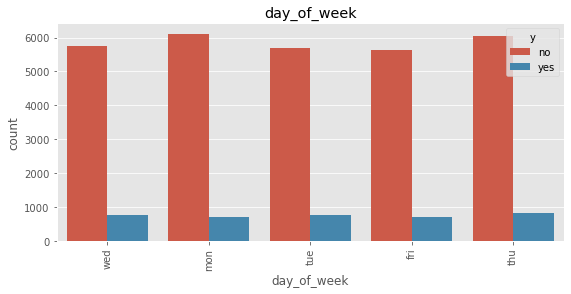

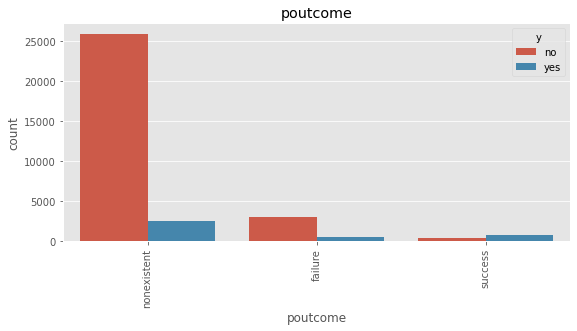

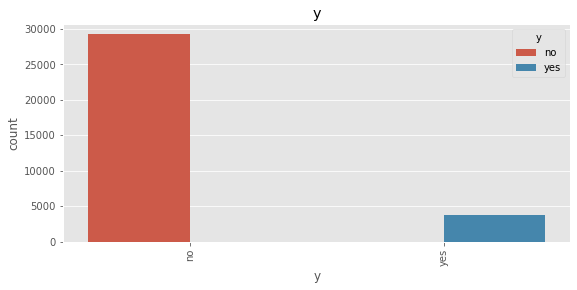

In [15]:
plt.style.use("ggplot")
for column in cat_var:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.countplot(data[column], hue=data["y"])
    plt.title(column)    
    plt.xticks(rotation=90)

### Observations:

- Customers having administrative jobs form the majority amongst those who have subscirbed to the term deposit.
- They are married 
- They hold a university degree
- They do not hold a credit in default
- Housing loan doesn't seem a priority to check for since an equal number of customers who have and have not subscribed to it seem to have subscribed to the term deposit.
- Cell-phones should be the preferred mode of contact for contacting customers.

### Handling Outliers
Outliers cause significant impact on the Mean and Variance.It becomes necessary to treat the outliers.

In [16]:
data.describe()

,age,duration,campaign
count,32950.000000,32950.000000,32950.000000
mean,40.014112,258.127466,2.560607
std,10.403636,258.975917,2.752326
min,17.000000,0.000000,1.000000
25%,32.000000,103.000000,1.000000
50%,38.000000,180.000000,2.000000
75%,47.000000,319.000000,3.000000
max,98.000000,4918.000000,56.000000


`age` `duration` and `campaign` are skewed towards right, we will compute the IQR and replace the outliers with the lower and upper boundaries

In [17]:
# compute interquantile range to calculate the boundaries
lower_boundries= []
upper_boundries= []
for i in ["age", "duration", "campaign"]:
    IQR= data[i].quantile(0.75) - data[i].quantile(0.25)
    lower_bound= data[i].quantile(0.25) - (1.5*IQR)
    upper_bound= data[i].quantile(0.75) + (1.5*IQR)
    
    print(i, ":", lower_bound, ",",  upper_bound)
    
    lower_boundries.append(lower_bound)
    upper_boundries.append(upper_bound)

age : 9.5 , 69.5
duration : -221.0 , 643.0
campaign : -2.0 , 6.0


In [18]:
lower_boundries

[9.5, -221.0, -2.0]

In [19]:
upper_boundries

[69.5, 643.0, 6.0]

In [20]:
# replace the all the outliers which is greater then upper boundary by upper boundary
j = 0
for i in ["age", "duration", "campaign"]:
    data.loc[data[i] > upper_boundries[j], i] = int(upper_boundries[j])
    j = j + 1  

Since, 
- for `age` the lower boundary (9.5) < minimum value (17)
- for `duration` and `campaigh` the lower boundaries are negative (-221.0), (-2.0) resp.<br>
replacing outliers with the lower boundary is not required

In [21]:
# without outliers
data.describe()

,age,duration,campaign
count,32950.000000,32950.000000,32950.000000
mean,39.929894,234.923915,2.271077
std,10.118566,176.854558,1.546302
min,17.000000,0.000000,1.000000
25%,32.000000,103.000000,1.000000
50%,38.000000,180.000000,2.000000
75%,47.000000,319.000000,3.000000
max,69.000000,643.000000,6.000000


After replacing the outliers with the upper boundary, the maximum values has been changed without impacting any other parameters like mean, standard deviation and quartiles.

### Encoding Categorical Features
Machine learning algorithm can only read numerical values. It is therefore essential to encode categorical features into numerical values

In [22]:
#categorical features
cat_var

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [23]:
# check categorical class
for i in cat_var:
    print(i, ":", data[i].unique())

job : ['blue-collar' 'entrepreneur' 'retired' 'admin.' 'student' 'services'
 'technician' 'self-employed' 'management' 'unemployed' 'housemaid']
marital : ['married' 'divorced' 'single']
education : ['basic.9y' 'university.degree' 'basic.4y' 'high.school'
 'professional.course' 'basic.6y' 'illiterate']
default : ['no' 'yes']
housing : ['no' 'yes']
loan : ['no' 'yes']
contact : ['cellular' 'telephone']
month : ['nov' 'jul' 'may' 'jun' 'aug' 'mar' 'oct' 'apr' 'sep' 'dec']
day_of_week : ['wed' 'mon' 'tue' 'fri' 'thu']
poutcome : ['nonexistent' 'failure' 'success']
y : ['no' 'yes']


Features like `job` `education` `month` `day_of_week ` has so many categories, we will Label Encode them as One Hot Encoding would create so many columns

In [24]:
# initializing label encoder
le= LabelEncoder()

# iterating through each categorical feature and label encoding them
for feature in cat_var:
    data[feature]= le.fit_transform(data[feature])

In [25]:
# label encoded dataset
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y
0,49,1,1,2,0,0,0,0,7,4,227,4,1,0
1,37,2,1,6,0,0,0,1,7,4,202,2,0,0
2,69,5,1,0,0,0,0,0,3,1,643,1,1,1
3,36,0,1,6,0,1,0,1,6,1,120,2,1,0
4,59,5,0,6,0,0,0,0,4,3,368,2,1,0


### Separating independent and dependent variables

In [26]:
# feature variables
x= data.iloc[:, :-1]

# target variable
y= data.iloc[:, -1]

### Checking Correlation of feature variables

<AxesSubplot:>

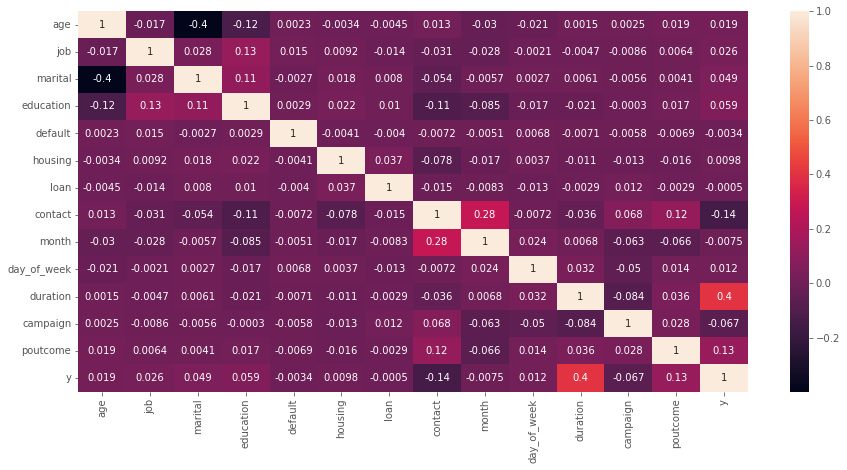

In [27]:
plt.figure(figsize=(15,7))
sns.heatmap(data.corr(), annot=True)

There are no features that are highly correlated and inversely correlated. If we had, we could have written the condition that if the correlation is higher than 0.8 (or can be any threshold value depending on the domain knowledge) and less than -0.8, we could have drop those features. Because those correlated features would have been doing the same job.

### Handling imbalanced dataset
Since the class distribution in the target variable is ~89:11 indicating an imbalance dataset, we need to resample it.

In [30]:
#initialising oversampling
smote= SMOTETomek(0.75)

#implementing oversampling to training data
x_sm, y_sm= smote.fit_resample(x,y)

# x_sm and y_sm are the resampled data

# target class count of resampled dataset
y_sm.value_counts()

0    28958
1    21648
Name: y, dtype: int64

### Splitting resampled data in train and test data

In [31]:
x_train, x_test, y_train, y_test= train_test_split(x_sm, y_sm, test_size=0.2, random_state=42)

## Randomizedsearch and hyperparameter tuning

### Logistic Regression

In [33]:
# selecting the classifier
log_reg= LogisticRegression()

# selecting hyperparameter tuning
log_param= {"C": 10.0**np.arange(-2,3), "penalty": ["l1", "l2"]}

# defining stratified Kfold cross validation
cv_log= StratifiedKFold(n_splits=5)

# using randomizedsearch for respective parameters
randomizedsearch_log= RandomizedSearchCV(log_reg, log_param, cv=cv_log, scoring= "f1_macro", n_jobs=-1, verbose=2)

# fitting the model on resampled data
randomizedsearch_log.fit(x_train, y_train)

# printing best score and best parameters
print("best score is:" ,randomizedsearch_log.best_score_)
print("best parameters are:" ,randomizedsearch_log.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best score is: 0.7927111031265254
best parameters are: {'penalty': 'l2', 'C': 0.1}


[[4982  833]
 [1127 3180]]


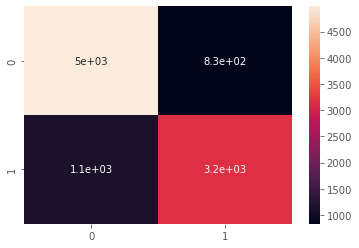

Accuracy:  0.8063623789764869
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      5815
           1       0.79      0.74      0.76      4307

    accuracy                           0.81     10122
   macro avg       0.80      0.80      0.80     10122
weighted avg       0.81      0.81      0.81     10122



In [36]:
# checking model performance
y_predicted= randomizedsearch_log.predict(x_test)

cm= confusion_matrix(y_test, y_predicted)
print(cm)
sns.heatmap(cm, annot=True)
plt.show()
print("Accuracy: ",accuracy_score(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

### Random Forest

In [37]:
# random forest
rf= RandomForestClassifier()

rf_param= { 
           "n_estimators": [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
           "max_features": ["auto", "sqrt", "log2"],
#            "max_depth": [4,5,6,7,8],
           "max_depth": [int(x) for x in np.linspace(start=5, stop=30, num=6)],
           "min_samples_split": [5,10,15,100],
           "min_samples_leaf": [1,2,5,10],
           "criterion":['gini', 'entropy'] 
          }

cv_rf= StratifiedKFold(n_splits=5)

randomsearch_rf= RandomizedSearchCV(rf, rf_param, cv=cv_rf, scoring= "f1_macro", n_jobs=-1, verbose=2, n_iter=10)

randomsearch_rf.fit(x_train, y_train)

print("best score is:", randomsearch_rf.best_score_)
print("best parameters are:", randomsearch_rf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

[[5264  558]
 [ 409 3901]]
0.9045598105013818
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      5822
           1       0.87      0.91      0.89      4310

    accuracy                           0.90     10132
   macro avg       0.90      0.90      0.90     10132
weighted avg       0.91      0.90      0.90     10132



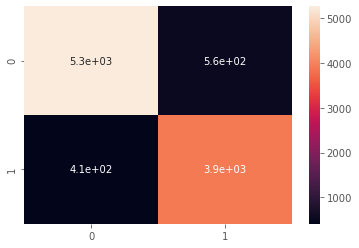

In [32]:
# checking model performance
y_predicted_rf= randomsearch_rf.predict(x_test)

print(confusion_matrix(y_test, y_predicted_rf))
sns.heatmap(confusion_matrix(y_test, y_predicted_rf), annot=True)
print(accuracy_score(y_test, y_predicted_rf))
print(classification_report(y_test, y_predicted_rf))

### Prediction on the Test dataset
We have to perform the same preprocessing operations on the test data that we have performed on the train data. But here we already have preprocessed data which is present in the csv file new_test.csv

In [33]:
test_data= pd.read_csv("../input/banking-dataset-classification/new_test.csv")
test_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
0,32,4,0,6,0,0,0,0,3,3,131,5,1
1,37,10,3,6,0,0,0,0,4,3,100,1,1
2,55,5,0,5,1,2,0,0,3,2,131,2,1
3,44,2,1,0,1,0,0,1,4,3,48,2,1
4,28,0,2,3,0,0,0,0,5,0,144,2,1


Random Forest classifier has given the best metric score on the validation data.

In [34]:
# predicting the test data
y_predicted= randomsearch_rf.predict(test_data)
y_predicted

array([0, 0, 0, ..., 1, 0, 0])

In [35]:
# dataset of predicted values for target variable y
prediction= pd.DataFrame(y_predicted, columns=["y_predicted"])
prediction_dataset= pd.concat([test_data, prediction], axis=1)
prediction_dataset

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y_predicted
0,32,4,0,6,0,0,0,0,3,3,131,5,1,0
1,37,10,3,6,0,0,0,0,4,3,100,1,1,0
2,55,5,0,5,1,2,0,0,3,2,131,2,1,0
3,44,2,1,0,1,0,0,1,4,3,48,2,1,0
4,28,0,2,3,0,0,0,0,5,0,144,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8233,48,4,1,2,0,2,0,0,6,3,554,1,1,1
8234,30,7,2,3,0,2,0,0,6,0,159,1,1,0
8235,33,7,1,3,0,0,0,0,4,1,472,1,0,1
8236,44,1,1,1,0,2,2,1,6,1,554,5,1,0
